# NPZD model with seasonality

### NPZD (Nutrient-Phytoplankton-Zooplankton-Detritus) model, modified from Sarmiento and Gruber (2006)

    - dN/dt = -Vmax*I/(I+KI)*N/(N+K)*P - ent*(N-Nth) + ld*D
    - dP/dt = Vmax*I/(I+KI)*N/(N+K)*P -g*P*Z/Kp - (lp+ent)*P
    - dZ/dt = a*g*P*Z/Kp - (lz+ent)*Z
    - dD/dt = lp*P + Z*( (1-a)*g*P/Kp+lz ) - (ld+ent)*D - Wsink/hml*D
    
    - Seasonal MLD = h0 + h1*( 1+cos(2*pi/360*t) )
    - Entrainment = 1/h*dhdt (if dhdt > 0) + c
    - Seasonal light = Io(t) = I0 + I1*( 1+cos(2*pi/360*t) ) W/m2
    - Average ML light = Io(t)*zI/hml(t)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# coefficients
h = 1 # timestep size
t = np.arange(0,360,h) # time in day
N = np.size(t) # dimension of time step
nuto = .001 # initial condition for nutrient
phyo = .001 # initial condition for phyto
zooo = .001 # initial condition for zoo
deto = .001 # initial condition for detritus
# set parameters
Vmax = 1.0 # per day
K = 0.1 # mmol/m3
Kp= 2.8 # mmol/m3
a = 0.4
g = 1.4 # per day
lp = 0.05 # per day
lz = 0.12 # per day
ld = 0.05 # per day
Nth = 10 # mmol/m3
Wsink=10 # m/day
c = 0.01 # 1/day, background mixing rate
#
h0 = 50 # m
h1 = 100 # m
#
I0 = 20 # W/m2
I1 = 150 # W/m2
#
zI = 20 #m
KI = 80 # W/m2

Text(0, 150, 'I,ave')

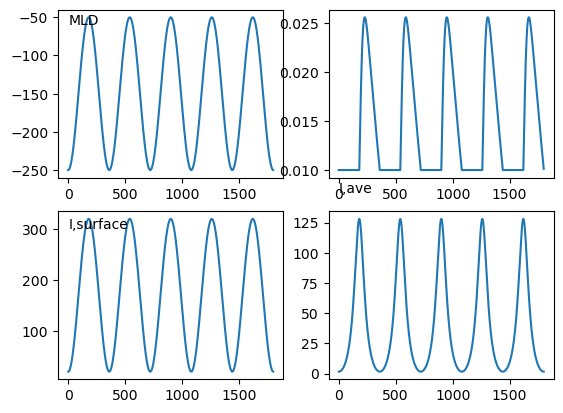

In [3]:
# evaluate seasonal cycle 
t = np.arange(0,360*5,1)
hml = h0+h1*(1+np.cos(2*np.pi/360*t))
dhdt= -h1*(2*np.pi/360)*np.sin(2*np.pi/360*t)
ent0=dhdt/hml
ent=np.where(ent0>0,ent0,0) + c
I=I0+I1*(1-np.cos(2*np.pi/360*t))
Iave=I*zI/hml
#
fig,ax=plt.subplots(2,2)
ax[0,0].plot(t,-hml)
ax[0,0].text(0,-60,'MLD')
ax[0,1].plot(t,ent)
ax[0,1].text(0,.001,'Entrainment')
ax[1,0].plot(t,I)
ax[1,0].text(0,300,'I,surface')
ax[1,1].plot(t,Iave)
ax[1,1].text(0,150,'I,ave')

In [4]:
def tendency(t,x,Vmax,K,Kp,a,g,lp,lz,ld,KI,Nth,zI,Wsink,c):
    nut=x[0]
    phy=x[1]
    zoo=x[2]
    det=x[3]
    hml = h0+h1*(1+np.cos(2*np.pi/360*t))
    dhdt= -h1*(2*np.pi/360)*np.sin(2*np.pi/360*t)
    ent0=dhdt/hml
    ent=np.where(ent0>0,ent0,0) + c
    I=I0+I1*(1-np.cos(2*np.pi/360*t))
    Iave=I*zI/hml
    dnutdt = -Vmax*nut/(nut+K)*phy*Iave/(Iave+KI) -ent*(nut-Nth) + ld*det
    dphydt = Vmax*nut/(nut+K)*phy*Iave/(Iave+KI) - zoo*g*phy/Kp - (lp+ent)*phy
    dzoodt = a*zoo*g*phy/Kp - (lz+ent)*zoo
    ddetdt = (1-a)*zoo*g*phy/Kp + lz*zoo + lp*phy - (ld+ent)*det -Wsink/hml*det
    out=np.array([dnutdt,dphydt,dzoodt,ddetdt])
    return out

In [5]:
# define model_run function
def model_run(trange,xinit,param,dt):
    # expand input
    Vmax = param[0]
    K = param[1]
    Kp= param[2]
    a = param[3]
    g = param[4]
    lp = param[5]
    lz = param[6]
    ld= param[7]
    KI = param[8]
    Nth = param[9]
    zI = param[10]
    Wsink=param[11]
    c = param[12]
    sol = solve_ivp(tendency,trange,xinit,args=(Vmax,K,Kp,a,g,lp,lz,ld,KI,Nth,zI,Wsink,c),method='RK45',max_step=dt)
    return sol

In [6]:
# set time range
trange = [0,360*5]
# set parameters
param=np.array([Vmax,K,Kp,a,g,lp,lz,ld,KI,Nth,zI,Wsink,c])
# set initial conditions
xinit = np.array([nuto,phyo,zooo,deto])
# time step size
h = 1
out = model_run(trange,xinit,param,h)

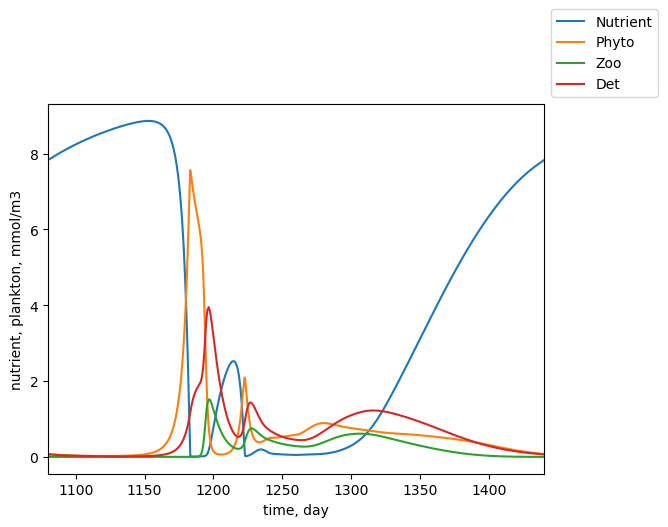

In [7]:
# plot the output
t_out = out.t
vec_out = out.y
N_out = vec_out[0,:]
P_out = vec_out[1,:]
Z_out = vec_out[2,:]
D_out = vec_out[3,:]
#
plt.plot(t_out,N_out,label='Nutrient')
plt.plot(t_out,P_out,label='Phyto')
plt.plot(t_out,Z_out,label='Zoo')
plt.plot(t_out,D_out,label='Det')
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('time, day')
plt.ylabel('nutrient, plankton, mmol/m3')
plt.xlim(360*3,360*4)
plt.show()